# Gluon CIFAR-10 Hyperparameter Tuning
_**ResNet model in Gluon trained with SageMaker Automatic Model Tuning and Random Search Tuning**_

---

---

_This notebook was created and tested on an ml.m4.xlarge notebook instance.  However, the tuning jobs use multiple ml.p3.8xlarge instances, meaning re-running this test could cost approximately \$400.  Please do not use Cell -> Run All.  Certain cell outputs have not been cleared so that you can see results without having to run the notebook yourself._

## Outline

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Script](#Script)
1. [Train: Initial](#Train:-Initial)
1. [Tune: Random](#Tune:-Random)
1. [Tune: Automatic Model Tuning](#Tune:-Automatic-Model-Tuning)
1. [Wrap-up](#Wrap-up)

## Background

Selecting the right hyperparameter values for your machine learning model can be difficult.  The right answer is dependent on your data; some algorithms have many different hyperparameters that can be tweaked; some are very sensitive to the hyperparameter values selected; and most have a non-linear relationship between model fit and hyperparameter values.

There are a variety of strategies to select hyperparameter values.  Some scientists use domain knowledge, heuristics, intuition, or manual experimentation; others use brute force searches; and some build meta models to predict what performant hyperparameter values may be.  But regardless of the method, it usually requires a specialized skill set.  Meanwhile, most scientists themselves would prefer to be creating new models rather than endlessly refining an old one.

Amazon SageMaker can ease this process with Automatic Model Tuning.  This technique uses Gaussian Process regression to predict which hyperparameter values may be most effective at improving fit, and Bayesian optimization to balance exploring the hyperparameter space (so that a better predictive model for hyperparameters can be built) and exploiting specific hyperparameter values when needed.

Other popular methods of hyperparameter optimization include brute force methods like random search.  Despite sounding naive, this is often very competitive.  However, we've found SageMaker's Automatic Model Tuning to provide better fits in fewer job runs, resulting in a better model with less time spent and at a lower cost.  This notebook will compare the two methods in more detail.

SageMaker's Automatic Model Tuning works with SageMaker's built-in algorithms, pre-built deep learning frameworks, and the bring your own algorithm container options.  But, for this example, let's stick with the MXNet framework, a ResNet-34 convolutional neural network, and the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image dataset.  For more background, please see the [MXNet CIFAR-10 example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/mxnet_gluon_cifar10/mxnet_cifar10_with_gluon.ipynb).

## Setup

Specify the IAM role for permission to access the dataset in S3 and SageMaker functionality.

In [ ]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

Let's import the necessary libraries.

In [ ]:
from sagemaker.mxnet import MXNet
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import random_tuner as rt
import pandas as pd
import matplotlib.pyplot as plt

---

## Data

We'll use a helper script to download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) training data and sample images.  CIFAR-10 consists of 60K 32x32 pixel color images (50K train, 10K test) evenly distributed across 10 classes.

In [ ]:
from cifar10_utils import download_training_data
download_training_data()

Next we'll use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value `inputs` identifies the location -- we will use this later when we start the training and tuning jobs.

In [ ]:
inputs = sagemaker_session.upload_data(path='data', key_prefix='data/DEMO-gluon-cifar10')
print('input spec (in this case, just an S3 path): {}'.format(inputs))

---

## Script

We need to provide a training script that can run on the SageMaker platform. This is idiomatic MXNet code arranged into a few key functions:
* A `train()` function that takes in hyperparameters, defines our neural net architecture, and trains our network.
* A `save()` function that saves our trained network as an MXNet model.
* Helper functions `get_data()`, `get_train_data()`, and `get_test_data()` which prepare the CIFAR-10 image data for our `train()` function.
* A helper function called `test()` which calculates our accuracy on the holdout datasets.
* Hosting functions (which we keep for alignment with other MXNet CIFAR-10 notebooks, but won't dig into since the focus of this notebook is only on training).

The network itself is a ResNet-34 architecture imported from the [Gluon Model Zoo](https://mxnet.incubator.apache.org/versions/master/api/python/gluon/model_zoo.html).

In [ ]:
!cat 'cifar10.py'

---

## Train: Initial

Now that we've written our training script, we can submit it as a job to SageMaker training.  Normally, we might test locally to ensure our script worked (See the [MXNet CIFAR-10 local mode example](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/mxnet_gluon_cifar10/mxnet_cifar10_local_mode.ipynb)), but since we already know the script works, we'll skip that step.

Let's see how our model performs with a naive guess for hyperparameter values.  We're training our network with stochastic gradient descent (SGD), which is an iterative method to minimize our training loss by finding the direction to change our network weights that improves training loss and then taking a small step in that direction and repeating.  Since we're using SGD, the three hyperparameters we'll focus on will be:

* `learning_rate`: which controls how large of steps we take.
* `momentum`: which uses information from the direction of our previous step to inform our current step.
* `wd`: which penalizes weights when they grow too large.

In this case, we'll set the hyperparameters to MXNet's default values.

In [ ]:
m = MXNet('cifar10.py',
          role=role,
          train_instance_count=1,
          train_instance_type='ml.p3.8xlarge',
          framework_version='1.4.1',
          py_version='py3',
          hyperparameters={'batch_size': 1024,
                           'epochs': 50,
                           'learning_rate': 0.01,
                           'momentum': 0.,
                           'wd': 0.})

Now that we've constructed our `MXNet` object, we can fit it using the data we uploaded to S3.

In [ ]:
m.fit(inputs)

As we can see, our accuracy is only about 53% on our validation dataset.  CIFAR-10 can be challenging, but we'd want our accuracy much better than just over half if users are depending on an accurate prediction.

---

## Tune: Random

One method of hyperparameter tuning that performs surprisingly well for how simple it is, is randomly trying a variety of hyperparameter values within set ranges.  So, for this example, we've created a helper script `random_tuner.py` to help us do this.

We'll need to supply:

* A function that trains our MXNet model given a job name and list of hyperparameters.  Note, `wait` is set to false in our `fit()` call so that we can train multiple jobs at once.
* A dictionary of hyperparameters where the ones we want to tune are defined as one of three types (`ContinuousParameter`, `IntegerParameter`, or `CategoricalParameter`) and appropriate minimum and maximum ranges or a list of possible values are provided.

In [ ]:
def fit_random(job_name, hyperparameters):
    m = MXNet('cifar10.py',
              role=role,
              train_instance_count=1,
              train_instance_type='ml.p3.8xlarge',
              framework_version='1.4.1',
              py_version='py3',
              hyperparameters=hyperparameters)
    m.fit(inputs, wait=False, job_name=job_name)

In [ ]:
hyperparameters = {'batch_size': 1024,
                   'epochs': 50,
                   'learning_rate': rt.ContinuousParameter(0.001, 0.5),
                   'momentum': rt.ContinuousParameter(0., 0.99),
                   'wd': rt.ContinuousParameter(0., 0.001)}

Next, we can kick off our random search.  We've defined the total number of training jobs to be 120.  This is a large amount and drives most of the cost of this notebook.  Also, we've specified up to 8 jobs to be run in parallel.  This exceeds the default concurrent instance limit for ml.p3.8xlarge instances.  If you're just testing this notebook out, decreasing both values will control costs and allow you to complete successfully without requiring a service limit increase.

_Note, this step may take up to 2 hours to complete.  Even if you loose connection with the notebook in the middle, as long as the notebook instance continues to run, `jobs` should still be successfully created for future use._

In [ ]:
%%time

jobs = rt.random_search(fit_random,
                        hyperparameters,
                        max_jobs=120,
                        max_parallel_jobs=8)

Once our random search completes, we'll want to compare our training jobs (which may take a few extra minutes to finish) in order to understand how our objective metric (% accuracy on our validation dataset) varies by hyperparameter values.  In this case, our helper function includes two functions.

* `get_metrics()` scrapes the CloudWatch logs for our training jobs and uses a regex to return any reported values of our objective metric.
* `table_metrics()` joins on the hyperparameter values for each job, grabs the ending objective value, and converts the result to a Pandas DataFrame.

In [31]:
random_metrics = rt.table_metrics(jobs, rt.get_metrics(jobs, 'validation: accuracy=([0-9\\.]+)'))
random_metrics.sort_values(['objective'], ascending=False)

,epochs,wd,batch_size,objective,learning_rate,job_number,momentum
random-hp-2018-07-08-20-06-10-189-17,50,0.000539,1024,0.736938,0.346114,17,0.231219
random-hp-2018-07-08-20-06-10-189-106,50,0.000658,1024,0.736572,0.203518,106,0.808102
random-hp-2018-07-08-20-06-10-189-78,50,0.000955,1024,0.735352,0.044036,78,0.962561
random-hp-2018-07-08-20-06-10-189-15,50,0.000304,1024,0.733887,0.187376,15,0.954231
random-hp-2018-07-08-20-06-10-189-16,50,0.000849,1024,0.733643,0.381012,16,0.049903
random-hp-2018-07-08-20-06-10-189-117,50,0.000708,1024,0.732544,0.314118,117,0.817854
random-hp-2018-07-08-20-06-10-189-70,50,0.000115,1024,0.732178,0.396326,70,0.510912
random-hp-2018-07-08-20-06-10-189-28,50,0.000593,1024,0.731689,0.398318,28,0.394819
random-hp-2018-07-08-20-06-10-189-2,50,0.000155,1024,0.731689,0.144946,2,0.924371
random-hp-2018-07-08-20-06-10-189-81,50,0.000810,1024,0.730103,0.351694,81,0.731069


As we can see, there's a huge variation in percent accuracy.  Had we initially (unknowingly) set our learning rate near 0.5, momentum at 0.15, and weight decay to 0.0004, we would have an accuracy just over 20% (this is particularly bad considering random guessing would produce 10% accuracy).

But, we also found many successful hyperparameter value combinations, and reached a peak validation accuracy of 73.7%.  Note, this peak job occurs relatively early in our search but, due to randomness, our next best objective value occurred 89 jobs later.  The actual peak could have occurred anywhere within the 120 jobs and will change across multiple runs.  We can see that with hyperparameter tuning our accuracy is well above the default value baseline of 53%.

To get a rough understanding of how the hyperparameter values relate to one another and the objective metric, let's quickly plot them.

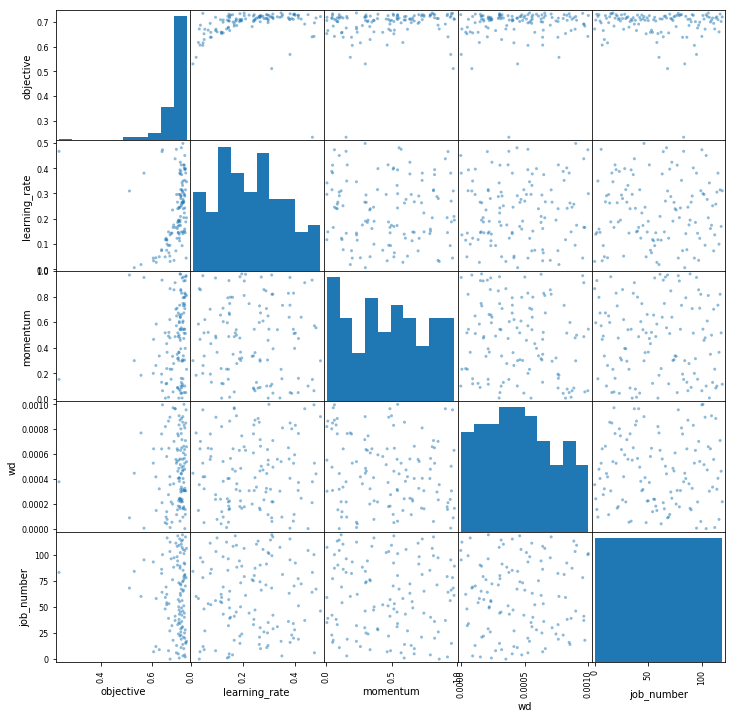

In [32]:
pd.plotting.scatter_matrix(random_metrics[['objective',
                                           'learning_rate',
                                           'momentum',
                                           'wd',
                                           'job_number']],
                           figsize=(12, 12))
plt.show()

The hyperparameter's correlation with themselves and over time is essentially non-existent (which makes sense because we selected their values randomly).  However, in general, we notice:

* Very low `learning_rate`s tend to do worse, although too high seems to add variability.
* `momentum` seems to have less impact, with potentially a non-linear sweet spot near 0.8.
* `wd` has a less consistent impact on accuracy than the other two hyperparameters.

---

## Tune: Automatic Model Tuning

Now, let's try using Amazon SageMaker's Automatic Model Tuning.  Rather than selecting hyperparameter values randomly, SageMaker builds a second machine learning model which, based on previous hyperparameter and objective metric values, predicts new values that might yield an improvement.  This should allow us to train better models, faster and cheaper.

We'll use the tuner functionality already built-in to the SageMaker Python SDK.  Let's start by defining a new `MXNet` estimator.

In [ ]:
mt = MXNet('cifar10.py',
           role=role,
           train_instance_count=1,
           train_instance_type='ml.p3.8xlarge',
           framework_version='1.4.1',
           py_version='py3',
           hyperparameters={'batch_size': 1024,
                            'epochs': 50})

Now we can define our ranges (these take the same arguments as the classes from `random_tuner`).

In [ ]:
hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.001, 0.5),
                         'momentum': ContinuousParameter(0., 0.99),
                         'wd': ContinuousParameter(0., 0.001)}

Now, we'll define our objective metric and provide the regex needed to scrape it from our training jobs' CloudWatch logs.

In [ ]:
objective_metric_name = 'Validation-accuracy'
metric_definitions = [{'Name': 'Validation-accuracy',
                       'Regex': 'validation: accuracy=([0-9\\.]+)'}]

Now we can create a `HyperparameterTuner` object and fit it by pointing to our data in S3.  This kicks our tuning job off in the background.

Notice, we specify a much smaller number of total jobs, and a smaller number of parallel jobs.  Since our model uses previous training job runs to predict where to test next, we get better results (although it takes longer) when setting this to a smaller value.

In [ ]:
tuner = HyperparameterTuner(mt,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=30,
                            max_parallel_jobs=2)

In [ ]:
tuner.fit(inputs)

_You will be unable to successfully run the following cells until the tuning job completes.  This step may take up to 2 hours._

Once the tuning job finishes, we can bring in a table of metrics.

In [13]:
bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuner._current_job_name).dataframe()
bayes_metrics.sort_values(['FinalObjectiveValue'], ascending=False)

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,learning_rate,momentum,wd
12,0.739868,449.0,2018-07-08 06:32:39+00:00,sagemaker-mxnet-180708-0457-018-0672e23c,Completed,2018-07-08 06:25:10+00:00,0.218998,7.807712e-01,0.000463
8,0.735352,484.0,2018-07-08 06:53:18+00:00,sagemaker-mxnet-180708-0457-022-602fe997,Completed,2018-07-08 06:45:14+00:00,0.491950,2.074798e-02,0.000330
11,0.734741,527.0,2018-07-08 06:42:58+00:00,sagemaker-mxnet-180708-0457-019-510b97e9,Completed,2018-07-08 06:34:11+00:00,0.495178,1.530975e-02,0.000864
14,0.732422,484.0,2018-07-08 06:22:48+00:00,sagemaker-mxnet-180708-0457-016-3c3a8322,Completed,2018-07-08 06:14:44+00:00,0.394037,7.685146e-01,0.000663
7,0.731079,486.0,2018-07-08 07:03:57+00:00,sagemaker-mxnet-180708-0457-023-feac622d,Completed,2018-07-08 06:55:51+00:00,0.443138,6.272739e-01,0.000891
0,0.730591,423.0,2018-07-08 07:35:16+00:00,sagemaker-mxnet-180708-0457-030-b96d5377,Completed,2018-07-08 07:28:13+00:00,0.095172,9.210969e-01,0.000408
1,0.729370,468.0,2018-07-08 07:35:32+00:00,sagemaker-mxnet-180708-0457-029-25c7583d,Completed,2018-07-08 07:27:44+00:00,0.400276,5.187911e-02,0.000631
28,0.729248,485.0,2018-07-08 05:07:29+00:00,sagemaker-mxnet-180708-0457-002-65adfb1f,Completed,2018-07-08 04:59:24+00:00,0.308497,8.221134e-01,0.000838
22,0.728027,471.0,2018-07-08 05:40:08+00:00,sagemaker-mxnet-180708-0457-008-a1ecd004,Completed,2018-07-08 05:32:17+00:00,0.202243,7.614848e-01,0.000937
15,0.727173,490.0,2018-07-08 06:19:35+00:00,sagemaker-mxnet-180708-0457-015-305bc5d4,Completed,2018-07-08 06:11:25+00:00,0.399027,7.784146e-01,0.000653


Looking at our results, we can see that, with one fourth the total training jobs, SageMaker's Automatic Model Tuning has produced a model with better accuracy 74% than our random search.  In addition, there's no guarantee that the effectiveness of random search wouldn't change over subsequent runs.

Let's compare our hyperparameter's relationship to eachother and the objective metric.

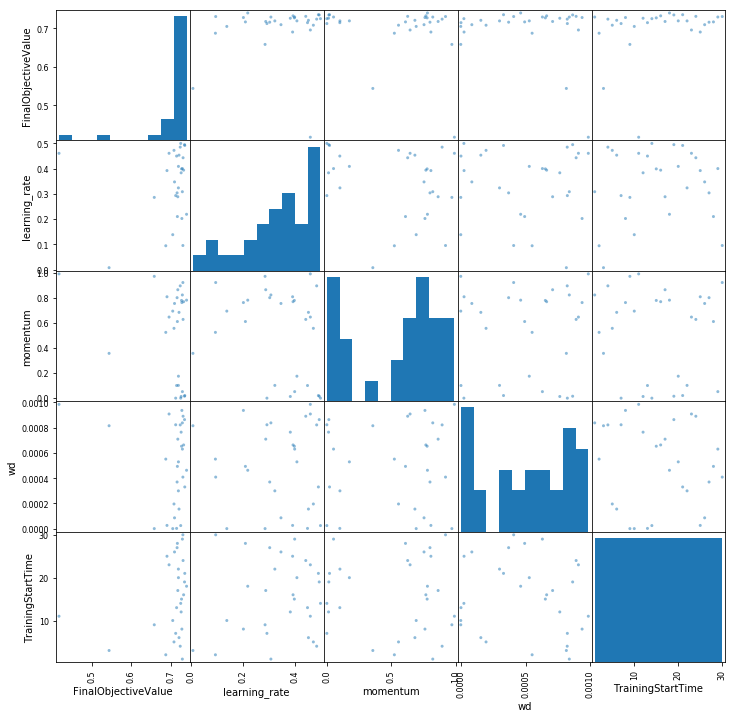

In [15]:
pd.plotting.scatter_matrix(pd.concat([bayes_metrics[['FinalObjectiveValue',
                                                     'learning_rate',
                                                     'momentum',
                                                     'wd']],
                                      bayes_metrics['TrainingStartTime'].rank()],
                           axis=1),
                           figsize=(12, 12))
plt.show()

We can see that:
* There's a range of reasonably good values for `learning_rate`, `momentum`, and `wd`, but there seem to be some very bad performers at both ends of the spectrum.
* Later training jobs performed consistently better than early ones (SageMaker's Automatic Model Tuning was learning and effectively exploring the space).
* There appears to be somewhat less of a random relationship between the hyperparameter values our meta-model approach tested.  This aligns with the knowledge that these hyperparameters are connected and that changing one can be offset by changing another.

---

## Wrap-up

In this notebook, we saw the importance of hyperparameter tuning and discovered how much more effective Amazon SageMaker Automatic Model Tuning can be than random search.  We could extend this example by testing another brute force method like grid search, tuning additional hyperparameters, using this first round of hyperparameter tuning to inform a secondary round of  hyperparameter tuning where ranges have been narrowed down further, or applying this same comparison to your own problem.

For more information on using SageMaker's Automatic Model Tuning, see our other [example notebooks](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/hyperparameter_tuning) and [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html).